### Numerical experiments on MNIST

In this notebook, we test the optimal strategy obtained for different values of $\Delta_F$, obtained with MNIST_b_trained.ipynb, on the MNIST dataset.

In [ ]:
import numpy as np
import casadi
from casadi import *
import matplotlib.pyplot as plt
from numpy.random import normal
from tqdm import tqdm
from sklearn.datasets import fetch_openml
from collections import defaultdict
import pickle

In [2]:
def extend_curve(v, N2):
    """
    Extend the input curve to length N2 by repeating and truncating.

    Parameters:
        curve (array-like): The original curve of length N.
        N2 (int): The desired extended length (N2 > len(curve)).

    Returns:
        np.ndarray: Extended curve of length N2.
    """
    N1 = len(v)
    x = np.linspace(0, 1, N1)  
    y = np.linspace(0, 1, N2, endpoint=False)  # new query points

    ret=[]
    count=0

    for i in range(N2):
        if y[i]>x[count]:
            count=count+1
        ret.append(v[count])
    

    return ret

In [3]:
K=2 #Number of Gaussian clusters (denoted C1 in the paper)
r=2 #Number of network hidden nodes (denoted K in the paper)

In [4]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.to_numpy() / 255.0 / 5 # normalize to [0,1]
y = mnist.target.astype(int)


# Group by digit
digit_data = defaultdict(list)
for img, label in zip(X, y):
    digit_data[label].append(img)


# Fit Gaussian model x = mu + sigma * z for each digit
mu_sigma_per_digit = {}
for digit in range(10):
    data = np.stack(digit_data[digit])
    mu = np.mean(data, axis=0)
    sigma_data = np.sqrt(np.mean((data - mu) ** 2))
    mu_sigma_per_digit[digit] = (mu, sigma_data)

In [5]:
mu0=mu_sigma_per_digit[0][0]
mu1=mu_sigma_per_digit[1][0]
N=len(mu0)#input dimension
P=len(digit_data[0])+len(digit_data[1])
p0=len(digit_data[0])/P
p1=len(digit_data[1])/P
T=1#alphaF
nsteps=int(T*N)
eta=5
Deltaf=0.4
b0=0.0

## Numerical simulations on MNIST

In [6]:
def generate_data(N,num_samples,sigmas,mus,cs):

    K,N=mus.shape
    coefficients = np.random.choice(K, size=num_samples, p=cs)
    X=np.array([mus[cf]+sigmas[cf]*normal(0,1.,size=N) for cf in coefficients])
    return X.reshape((num_samples,N))

In [7]:
def compute_gradient(w,b,x,xi,Delta):
    r,N=w.shape
    xt=np.sqrt(1-Delta)*x+np.sqrt(Delta)*xi

    error=x-b*xt-w.T@w@xt/N
    lbdt=w@xt
    Q=w@w.T/N
    
    Lbd=w@x-b*lbdt-Q@lbdt
    dw=-(np.outer(lbdt,error)+np.outer(Lbd,xt))/N
    db=-np.dot(xt,error)/N**2
    return dw,db

In [8]:
def compute_mse(w,b,Xtest,Delta):
    
    nsamp,N=Xtest.shape
    
    Xt=np.sqrt(1-Delta)*Xtest+np.sqrt(Delta)*normal(0,1.,size=(nsamp,N))
    lbt=Xt@w.T/np.sqrt(N)

  

    Xpred=b*Xt+lbt@w/np.sqrt(N)
    
    return np.mean(np.sum((Xpred-Xtest)**2,axis=1))

In [9]:
def run_simulations(w0,b0,etas,Deltas,num_steps,X_train,X_test,N,K,r,Deltaf,downsampling=1):
    
    
    n_downsampling=num_steps//downsampling
    W=np.zeros((r,N))
    bsim=np.zeros(num_steps+1)
    
    errors=np.zeros(n_downsampling+1)

    W=w0.copy()
    bsim[0]=b0
   
    X=X_train

    Xtest=X_test
    count=0
    for t in tqdm(range(num_steps)):
        xi=normal(0,1.,size=N)
        dw_sim,db_sim=compute_gradient(W,bsim[t],X[t],xi,Deltas[t])
        W=W-etas[t]*dw_sim
        bsim[t+1]=bsim[t]-etas[t]*db_sim
        if t%downsampling==0: 
            errors[count]=compute_mse(W,bsim[t+1],Xtest,Deltaf)
            count=count+1

        

    return W,bsim,errors

In [10]:
num_steps=nsteps
etas=np.ones(num_steps+1)*eta
Deltas=np.ones(num_steps+1)*Deltaf
Deltas_zero=np.zeros(num_steps+1)
alphasim=np.array(range(num_steps+1))/N

In [11]:
np.random.seed(195)
mus=np.array([mu0,mu1])
musNormalized=np.array([mu0/np.linalg.norm(mu0),mu1/np.linalg.norm(mu1)])
cs=[p0,p1]
sigmas=[mu_sigma_per_digit[0][1],mu_sigma_per_digit[1][1]]
#Initializations
mutmp=np.concatenate((mus,mus),axis=0)
weights_0=0.2*musNormalized+normal(0,1/np.sqrt(N),size=(r,N))
weights_0=np.array([weights_0[p]*np.sqrt(N)/np.linalg.norm(weights_0[p]) for p in range(r)])
downsampling=20

In [12]:
data=np.array(digit_data[0]+digit_data[1])
np.random.shuffle(data)
data_train=data[:nsteps]
data_test=data[nsteps:]

In [13]:
M0=mus@weights_0.T/np.sqrt(N)
Q0=weights_0@weights_0.T/N
S=mus@mus.T

In [14]:
W,bsim,errors=run_simulations(weights_0,b0,etas,Deltas,num_steps,data_train,data_test,N,K,r,Deltaf,downsampling=downsampling)

100%|██████████| 784/784 [00:14<00:00, 52.35it/s]


## Plots

In [15]:
colors = [
    "#E69F00",  # orange
    "#0072B2",  # blue
    "#009E73",  # green
    # "#F0E442",  # yellow
    "#D55E00",  # red/orange (vermillion)
    "#CC79A7",  # pink/purple
    "#999999",  # grey (neutral tone)
    "navy"
]
markers=['o','X','s','D','^','<','v']

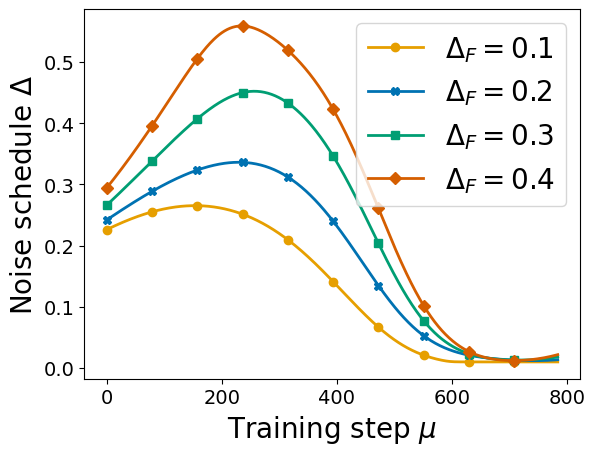

In [16]:
i=0
for Deltaf in [0.1,0.2,0.3,0.4]:
    with open(f'data/schedule_Delta={Deltaf}_Treal={T}_eta={eta}.pickle', 'rb') as handle:
        Deltas_opt=pickle.load( handle)
    itsDelta=np.linspace(0,num_steps,len(Deltas_opt))
    plt.plot(itsDelta,Deltas_opt,linewidth=2,color=colors[i],marker=markers[i],markevery=50,label=f"$\\Delta_F=${Deltaf}",markersize=6,
             linestyle='-')
    i=i+1
plt.ylabel(r"Noise schedule $\Delta$",fontsize=20)
plt.xlabel(r"Training step $\mu$",fontsize=20)
plt.legend(fontsize=20)
plt.tick_params(axis='both', labelsize=14)




100%|██████████| 784/784 [00:53<00:00, 14.64it/s]
/var/folders/3j/s6mqx7756_34d9638445dgzh0000gq/T/ipykernel_15428/1030257941.py:31: RuntimeWarning: divide by zero encountered in divide
  MSEimpr=(errors-errorsopt)*100/(errors[0]-errors)
100%|██████████| 784/784 [00:53<00:00, 14.61it/s]
/var/folders/3j/s6mqx7756_34d9638445dgzh0000gq/T/ipykernel_15428/1030257941.py:32: RuntimeWarning: invalid value encountered in add
  MSEavg=MSEavg+MSEimpr
100%|██████████| 784/784 [00:50<00:00, 15.41it/s]


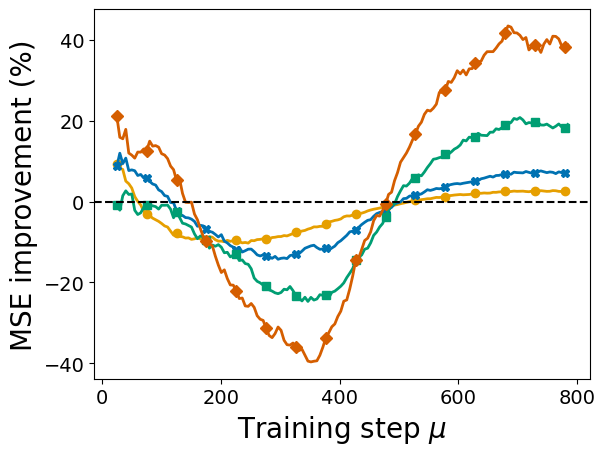

In [17]:
i=0
downsampling=5

averaging=10

for Deltaf in [0.1,0.2,0.3,0.4]:

    
    with open(f'data/schedule_Delta={Deltaf}_Treal={T}_eta={eta}.pickle', 'rb') as handle:
        Deltas_opt=pickle.load( handle)

    
    Deltas=np.ones(num_steps+1)*Deltaf

    Deltas_opt2=extend_curve(Deltas_opt, num_steps+1)
    
    MSEavg=np.zeros(num_steps//downsampling+1)

    for _ in range(averaging):

        np.random.shuffle(data)
        data_train=data[:nsteps]
        data_test=data[nsteps:]

        W,bsim,errors=run_simulations(weights_0,b0,etas,Deltas,num_steps,data_train,data_test,N,K,r,Deltaf,downsampling=downsampling)
        
        
        Wopt,bsimopt,errorsopt=run_simulations(weights_0,b0,etas,Deltas_opt2,num_steps,data_train,data_test,N,K,r,Deltaf,downsampling=downsampling)


        MSEimpr=(errors-errorsopt)*100/(errors[0]-errors)
        MSEavg=MSEavg+MSEimpr
    
    MSEavg=MSEavg/averaging

    itsMSE=np.linspace(0,num_steps,len(MSEavg))
    plt.plot(itsMSE[5:],MSEavg[5:],linewidth=2,color=colors[i],marker=markers[i],markevery=10,label=f"$\\Delta_F=${Deltaf}",markersize=6,
             linestyle='-')
    i=i+1
plt.axhline(0, color='k', linestyle='--')
plt.ylabel("MSE improvement (%)", fontsize=20)
plt.xlabel(r"Training step $\mu$",fontsize=20)
#plt.legend(fontsize=20)
plt.tick_params(axis='both', labelsize=14)